<a href="https://colab.research.google.com/github/GatitoNegro/Mentoria-2021-Anaisis-de-quejas/blob/main/Notebook_GUVs_V3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto-Integrador-Determinacion-de-rigidez-de-biomembrana-usando-GUVs**

# **GUVis GUVis**

Determinación de la rigidez a la flexión de biomembranas mediante el análisis de la fluctuación de su forma a partir de imágenes provenientes de videos de microscopía

#### **Autores:**
####       **Amante, Sofia Veronica**
####       **Scurti, Pablo Ezequiel**

##### **Córdoba, septiembre de 2022** 

Manual instructivo: https://github.com/GatitoNegro/Determinacion-de-rigidez-de-biomembrana-usando-GUVs/blob/main/Instructivo%20de%20utilizaci%C3%B3n%20-%20plataforma%20Colaboratory.pdf

In [ ]:
pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 5.3 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=375d25160b31aa07824b820cbdacd693915170e6bc6a6b40a62a2e7ac21c84d5
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [ ]:
pip install numpy==1.21.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#*Instructivo:*#
>>*Primero conectar el entorno de ejecución desde el botón a la derecha que dice conectar*
-
*Luego cargar el video a analizar en la plataforma: a la izquiera aparecen cuatro íconos, presionar el ícono final ,"Archivos". Se abrirá una nueva sección, en ésta presionar el ícono con el PAPEL BLANCO con una flecha hacia arriba (el que está abajo de la palabra archivos, no la carpeta con la flecha), se abrirá una ventana que nos permite selecionar el video y lo cargamos*  - 
*A medida que avanzamos en el código vamos presionando el ícono de play en cada bloque*
- *Para reiniciar, desconectar entorno (arriba a la derecha) y volver a conectar.*

**GUVs**

Importamos las librerias necesarias

In [ ]:
import numpy as np  # procesamiento matricial
import imageio# para leer/guardar videos
import matplotlib.pyplot as plt  # para mostrar imagenes
import cv2 
from google.colab.patches import cv2_imshow
import scipy.special as sc
import math as mt
plt.rcParams['image.cmap'] = 'gray'


print(np.__version__)
print(imageio.__version__)
print(cv2.__version__)


1.21.6
2.4.1
4.6.0


Vemos el video y obtenemos sus dimensiones: 
- Cantidad de frames o fotogramas del video
- Tamaño de la imagen en pixeles de ancho
- Tamaño de la imagen en pixeles de alto
- Cantidad de capas, en este caso al ser RGB es 3 

>>*En el siguiente bloque debemos colocar ingresar el nombre del video, junto con el formato, entre comillas ejemplo: "video.mp4". 
Los formatos aceptados son solo mp4*

In [ ]:
vid_reader = imageio.get_reader("Fl.mp4")
mdata = vid_reader.get_meta_data() # ver los metadatos del video
cant_frames= vid_reader.get_length() #longitud
dimensiones = (cant_frames, mdata['source_size'][1], mdata['source_size'][0],3)
print(dimensiones)

(2175, 212, 216, 3)


Creamos una matriz con las dimensiones obtenidas. 
Cargamos el video en la matriz creada. Esto se realiza fotograma por fotgrama. 

In [ ]:
video_np = np.zeros(dimensiones)
n=0
for i in vid_reader:
  video_np[n,:,:,:]=i
  n=n+1

vid_reader.close() # cerrar lector de video

Creamos una matriz para guardar el video en escala de grises.
Durante el guardado se realiza la conversion a grises.

In [ ]:
dimensiones_gris = (cant_frames, mdata['source_size'][1], mdata['source_size'][0]) 
video_np_gris = np.zeros(dimensiones_gris) # se crea una matriz de ceros
for i in range(cant_frames):
       video_np_gris[i,:,:]=(video_np[i,:,:,0]+video_np[i,:,:,1]+video_np[i,:,:,2])/3 
       #video_np_gris[i,:,:]=np.rot90(video_np_gris[i,:,:],2)


>> *A continuación se debe ingresar la escala del video utilizado en pixeles por micrometros.*

In [ ]:
escala=input('Ingrese escala en micrometros por pixel: ')
escala=np.float64(escala)
print(escala)

Ingrese escala en micrometros por pixel: 0.1
0.1


>> *Con el siguiente bloque podemos eliminar frames en el caso que sea nesesario para este video* - *el codigo nos pregunta si queremos utilizar este bloque, en caso de si, nos pregunta si deseamos eliminar solo un frame aislado o varios frames consecutivos, en el segundo caso nos permte igresar el primer frames a eliminar y luego cuantos frames a partir de este eliminaremos*

In [ ]:
a=input('Desea eliminar algun frame si/no: ')
if a=='si':
  varios=input('Desea eliminar frames consecutivos si/no: ')
  if varios=='no':
    f=input('Fotograma a eliminar: ')
    video_np_gris=np.delete(video_np_gris,int(f),0)
  if varios=='si':
    f=input('Inicio de eliminzación: ')
    cantidad=input('Cantidad de fotogramas consecutivos: ' )
    for o in range(int(cantidad)):
      video_np_gris=np.delete(video_np_gris,int(f),0)

Desea eliminar algun frame si/no: no


Verificamos el nuevo valor de frames del video.

In [ ]:
cant_frames= video_np_gris.shape[0]
print (f'El nuevo numero de fotogramas es: {cant_frames}.')

El nuevo numero de fotogramas es: 2175.


PRUEBA: En el siguiente bloque se realizaran pruebas de los parametros de filtrado y binarizacion del frame que elejimos.
Se le aplica un filtro de mediana con una ventana n1.
Se encuentran los contornos.
Se eliminan contornos pequeños, si los hay.

>> *en este bloque podemos manipular los parametros n1, vecindad, constante y n2* 
- *frame: el frame que vamos a probar 
- *N1 es el tamaño de la ventana del primer filtro, debe ser un numero positivo impar. recomendado entre 5 y 9 , a mayor numero genera un mayor difiminado en la imagen*
- *Vecindad es el área alrededor de cada punto, utilizada para definir el umbral en la binarizacion adaptativa. Es un número definido en pixeles y debe ser un número impar positivo. Recomendado 5 a 35 a medida que el valor se hace mas grande el valor de mediana encontrado sera mas global de toda la imagen, con valores entre 5 y 35 nos sirve para imagenes que tienen una membrana que se ve en algunas partes muy brillante y en otras mas apagadas*
- *Constante es un numero de ajuste que se sumará al umbral encontrado por la función de binarización adaptativa, debe ser un numero menor o igual a cero.recomendado 0 a -8 este valor al ser mas negativo puede disminuir el grosor de la membrana*
- *N2 es el tamaño de la ventana del segundo filtro, debe ser un numero positivo impar. Recomendado entre 3 y 7 es un filtro que eliminara pequeños ruidos que puedan surguir de la binarizacion si no posee ruidos luego de la binarizzacion este valor puede ser 1 en tal caso queda sin efecto*

Contornos encontrados: 3
Quedador 2 contornos el resto se descarto


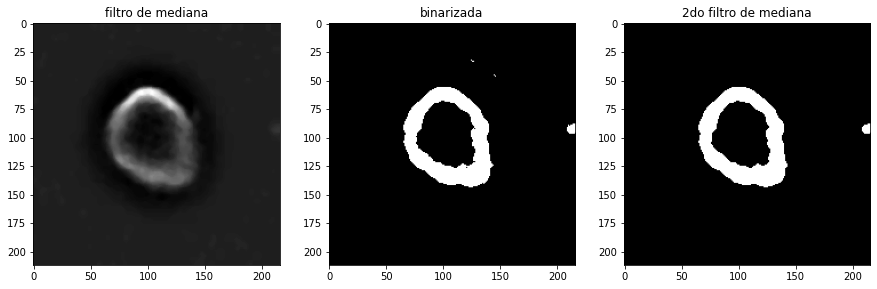

In [ ]:
frame=1092
n1=5
vecindad=75
constante=-2
n2=3

imagen=video_np_gris[frame,:,:]
imagen = np.uint8(imagen)
median = cv2.medianBlur(imagen,n1)#filtro de la mediana con kernel 
binarizada2 = cv2.adaptiveThreshold (median , 255 , cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY, vecindad,constante) 
binarizadam = cv2.medianBlur(binarizada2,n2)#filtro de la mediana con kernel 
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.subplot(1,3,1),plt.imshow(median)
plt.title("filtro de mediana")
plt.subplot(1,3,2),plt.imshow(binarizada2)
plt.title("binarizada")
plt.subplot(1,3,3),plt.imshow(binarizadam)
plt.title("2do filtro de mediana")
contorn,hierarchy=cv2.findContours(binarizadam,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
print(f"Contornos encontrados: {len(contorn)}")
contorn=list(contorn)
j=0
while len(contorn)>2:
  if  contorn[j].shape[0]<130:    
    del(contorn[j])
    j=j-1
  j=j+1
  if j==len(contorn) and len(contorn)>2:
    print(f"Advertencia, hay mas de 2 contornos de tamaño considerable, en el frame:{frame}")
    break    
if len(contorn)<2:
  print(f"Advertencia, hay menos de 2 contornos de tamaño considerable, en el frame:{frame}")
if len(contorn)==2:
  if  contorn[1].shape[0]<130:
    del(contorn[1])
    print(f"Advertencia, hay menos de 2 contornos de tamaño considerable, en el frame:{frame}")
  if  contorn[0].shape[0]<130:
    del(contorn[0])
    print(f"Advertencia, hay menos de 2 contornos de tamaño considerable, en el frame:{frame}")
print(f"Quedador {len(contorn)} contornos el resto se descarto")

FUNCION filtro mediana , binarizacion adaptativa,segundo filtro mediana

In [ ]:
def binarizar(imagen,n1,n2,v,c):
  median = cv2.medianBlur(imagen,n1)#filtro de la mediana con kernel, n ingresa
  binarizada = cv2.adaptiveThreshold (median,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY ,v,c) 
  binarizadaf =cv2.medianBlur(binarizada,n2)#filtro de la mediana con kernel 
  return binarizadaf

FUNCION centro de masa coordenadas

In [ ]:
def calcularcentro(bin):
  M1 = cv2.moments(bin)
  if M1["m00"]==0: M1["m00"]=1
  cX1 = int(M1["m10"] / M1["m00"])
  cY1 = int(M1["m01"] / M1["m00"])
  # put text and highlight the center
  coord= (cX1, cY1)
  return coord

FUNCION cálculo de contorno y eliminación contornos pequeños encontrados.

In [ ]:
def calcularcontorno(binarizadam,frame):
  contorn,hierarchy=cv2.findContours(binarizadam,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  contorn=list(contorn)
  j=0
  while len(contorn)>2:
    if  contorn[j].shape[0]<130:    
      del(contorn[j])
      j=j-1
    j=j+1
    if j==len(contorn) and len(contorn)>2:
      print(f"advertencia, hay mas de 2 contornos de tamaño considerable,en el frame:{frame}")
      break    
  if len(contorn)<2:
    print(f"advertencia, hay menos de 2 contornos de tamaño considerable,en el frame:{frame}")

  if len(contorn)==2:
    if  contorn[1].shape[0]<130:
      del(contorn[1])
      print(f"advertencia, hay menos de 2 contornos de tamaño considerable,en el frame:{frame}")
    if  contorn[0].shape[0]<130:
      del(contorn[0])
      print(f"advertencia, hay menos de 2 contornos de tamaño considerable,en el frame:{frame}")
  return contorn


A la función "dibujar contorno" se le da la lista de contornos y el contorno a dibujar (0 = exterior), entrega una imagen con el contorno dibujado en espesor 2 en color blanco. Las dimensiones de la imagen son tomadas de la variable global dimensiones(dimensiones del video). 

In [ ]:
def dibujarcontorno(cont,a):
  dibujo =np.zeros((dimensiones[1],dimensiones[2]))
  cv2.drawContours(dibujo, cont, a, 255, 2)
  return dibujo

A la función "calcular polares", se le da el contorno y el centro de masas.

In [ ]:
def calcularpolares(cont,cm):
  radiocomponentes=cont-cm
  radio=pow((pow(radiocomponentes,2).sum(axis=-1)),1/2).round(2) #Axis no entendi
  angulo=(np.arctan2(radiocomponentes[:,:,1], radiocomponentes[:,:,0]) * 180 / np.pi).round(2)

  pol=np.append(angulo,radio,axis=1)
  return pol

FUNCION primero escalonamos los ángulos cada dos grados, luego promediamos los radios encontrados de cada escalones. Discretizamos las cordenadas polares a v valores (por ejemplo, 120 valores), devuelve v valores de coordenadas ordenados de -180 a +180 grados. Si para algún ángulo en particular no hay valores de radio encontrados, el módulo del final promedia los valores adyacentes y le asigna al faltante.

In [ ]:
def discretizar(pol,v):
  n=-1 ##discretiza los valores del angulo con escalon de v grados
  for i in pol[:,0]: 
    n=n+1
    encontrado=0
    ma=180
    mi=180-(360/v)
    while encontrado==0:
      if i<=ma and i>mi:
        pol[n,0]=ma
        encontrado=1
      ma=ma-(360/v)
      mi=mi-(360/v)
  pol_ord=pol[np.lexsort(np.fliplr(pol).T)] #OREDENAMOS

  discretizada=np.zeros((v,2))
  c=-1
  for i in discretizada[:,0]:
    c=c+1
    discretizada[c,0]=180-(360/v)*c
  discretizada_ord =np.sort(discretizada,axis=0)

    ##promedia los radios con el mismo angulo
  k=0 #recorrera matriz original
  u=0 #acumulador valores
  l=1 #recorrera matriz nueva
  o=0 #cuenta valores iguales para poder promediar
  e=0 #cuenta errores de falta de radios para algun angulo se utilizara a modo de bandera
  pol_ord=np.append(pol_ord, [[555,555]], axis=0)#se agrega un valor aleatorio al final, para indicar el final.
  while l<=v:
    while pol_ord[k,0]==-180+(l*(360/v)):
      u=u+pol_ord[k,1]
      o=o+1
      k=k+1
    if o==0:
      #print(f"error, no hay valores para el angulo {discretizadaINord[l-1,0]} grados")
      o=1 #evita div por 0
      e=e+1
    discretizada_ord[l-1,1]=u/o
    l=l+1
    o=0
    u=0

  if e!=0 and e<20:
    #ARREGLA FALTA DE ANGULOS 
    m=0
    while m<len(discretizada_ord):
      if discretizada_ord[m,1]==0:
        if m==0:
          discretizada_ord[m,1]=(discretizada_ord[(len(discretizada_ord))-1,1]+discretizada_ord[m+1,1])/2
          #Si la primera punta no tiene valor, entonces saca promedioentre el sig elemento y la otra punta
        if m==len(discretizada_ord)-1==0:
          discretizada_ord[m,1]=(discretizada_ord[0,1]+discretizada_ord[m-1,1])/2
        #Si la otra punta no tiene elemento saca promedio entre el penultimo elemento y la primera punta
        discretizada_ord[m,1]=(discretizada_ord[m-1,1]+discretizada_ord[m+1,1])/2
        #Si el cero esta en cualquier otra parte saca el promedio entre el anterior y el siguiente elemento.
      m=m+1

  return discretizada_ord

FUNCION: Se entrega la matriz de coordenadas polares discretizada y entrega los coficientes a y b.

In [ ]:
def calcularcoeficientes(discre):
  An=np.zeros([50])
  for n in range(1,51):
    cos=np.cos(n*discre[:,0]*np.pi/180)
    cos_radio=cos*discre[:,1]
    sumatoria=0
    for h in range(cos_radio.shape[0]):
      suma=cos_radio[h]+cos_radio[(h+1)%cos_radio.shape[0]]
      resta=discre[(h+1)%cos_radio.shape[0],0]*np.pi/180-discre[h,0]*np.pi/180
      if (h+1)%cos_radio.shape[0]==0:
        resta=resta+2*np.pi
      producto=suma*resta
      sumatoria=sumatoria+producto
    An[n-1]=sumatoria/(2*np.pi)

  Bn=np.zeros([50])
  for n in range(1,51):
    sin=np.sin(n*discre[:,0]*np.pi/180)
    sin_radio=sin*discre[:,1]
    sumatoria=0
    for h in range(sin_radio.shape[0]):
      suma=sin_radio[h]+sin_radio[(h+1)%sin_radio.shape[0]]
      resta=discre[(h+1)%sin_radio.shape[0],0]*np.pi/180-discre[h,0]*np.pi/180
      if (h+1)%sin_radio.shape[0]==0:
        resta=resta+2*np.pi
      producto=suma*resta
      sumatoria=sumatoria+producto
    Bn[n-1]=sumatoria/(2*np.pi)
  return (An,Bn)

Prueba de las funciones anteriores

Centro de masas: (104, 100).
Coordenadas: (104, 100).
Cantidad de contornos: 2.
Datos de contorno externo: 234.
Datos de contorno interno: 161.


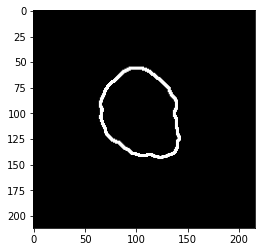

In [ ]:
binari=binarizar (imagen, n1,n2,vecindad, constante)
contorno=calcularcontorno(binari,frame)
dibujocontorno =dibujarcontorno(contorno,0)
coordenadas= calcularcentro (dibujocontorno)
print (f'Centro de masas: {coordenadas}.')
plt.imshow(dibujocontorno)
print(f'Coordenadas: {coordenadas}.')
print(f'Cantidad de contornos: {len(contorno)}.')
print(f'Datos de contorno externo: {contorno[0].shape[0]}.')
print(f'Datos de contorno interno: {contorno[-1].shape[0]}.')

In [ ]:
polares= calcularpolares(contorno[0],coordenadas)
print(polares.shape)
disc=discretizar(polares,180)
print(disc.shape)
An,Bn=calcularcoeficientes(disc)
print(An,Bn)

(234, 2)
(180, 2)
[ 8.84783096e-03 -2.67943505e+00 -2.00323152e+00 -7.41207332e-01
 -4.38046102e-01 -4.02344097e-01  6.03524797e-01  7.58210146e-02
 -3.33566387e-01 -1.25201356e-01 -1.36628008e-01 -1.86220617e-01
 -4.30730026e-02 -2.35604269e-01 -4.54238165e-02 -4.82833449e-03
 -2.04877317e-02 -6.86578376e-02 -9.91674477e-02 -3.64919586e-02
  6.21494852e-02  4.84519033e-02 -1.18747999e-01  3.30960963e-02
 -3.69001312e-02 -6.44585502e-03 -5.00432363e-02 -5.50688424e-05
 -2.04551637e-02 -6.01851852e-03  1.70671781e-02  5.71674341e-02
  1.40801094e-02 -2.83488026e-03  4.00017619e-02 -1.12110398e-02
 -6.91347629e-02 -4.11088241e-02  9.69409319e-03 -5.62172898e-02
  4.22713120e-02  3.40041193e-02  7.82514405e-02  4.32447838e-02
  1.38796296e-02 -2.26562596e-02  5.84882807e-03 -4.36215950e-02
  1.17628242e-02 -4.74853442e-02] [ 3.06907123e-01  3.55586642e+00  1.21374521e+00 -1.03182881e+00
 -1.20352616e+00 -6.84029656e-01 -2.16413315e-01  1.25231985e-01
  1.76981796e-02 -1.75850966e-01 -2.60

Prueba dibujo de contornos exterior. 
Al calcuar el centro de masas sobre esta imagen nos independizamos de otras vesiculas o manchas quw pueda haber por fuera de la vesicula principal.

In [ ]:
if cant_frames > 99:
  p=cant_frames//99
else:
  p=1

>> *En el siguiente bloque veremos el contorno encontrado para 100 frame estos estan distibuidos uniformemente en el caso de que el video contenga más de 100 frames, ejemplo si tenemos 500 frames veremos el 5 en el primer cuadro, luego el 10, 15...* - *el número de frame puede visualizarse arriba de cada cuadro*

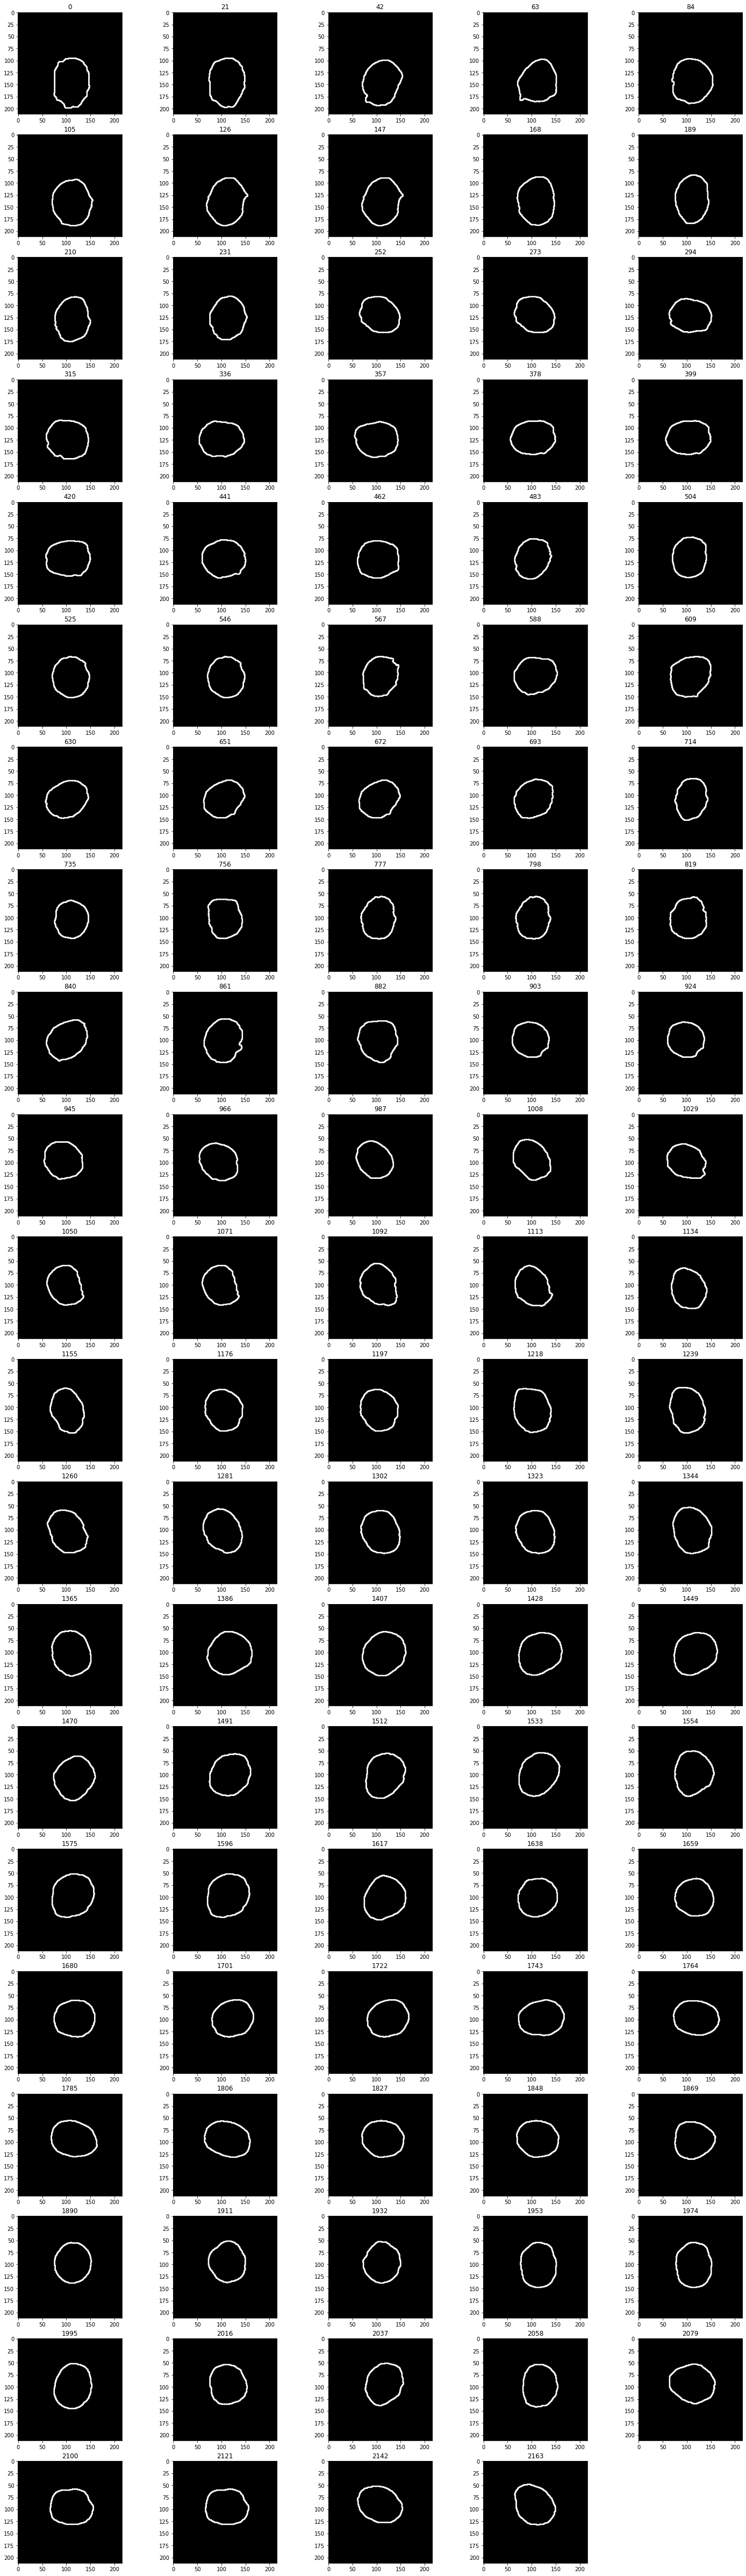

In [ ]:
fig = plt.gcf()
fig.set_size_inches(25,125)
e=0
for i in range(0,cant_frames,p):
  e=e+1
  imagen = video_np_gris[i,:,:]
  imagen = np.uint8(imagen)
  binari = binarizar (imagen, n1,n2,vecindad,constante)
  contorno = calcularcontorno(binari,i)
  dibujocontorno = dibujarcontorno(contorno,0)
  #print(i)
  plt.subplot(30,5,e),plt.imshow(dibujocontorno)
  plt.title(i)

>> En el siguiente bloque podemos cambiar en la primera linea la cantidad de escalones con la que se discretiza el contorno para el barrido angular, 360 puntos , 180 puntos, 120 puntos o 60 puntos, la eleccion estos valores dependen de la cantidad de puntos encontrados en el contorno que a su vez depende de el tamaño de la vesicula dentro de la imaguen y de la cantidad de pixeles la imaguen.

Aplicamos las funciones anteriores para obtener los coeficientes _aq_ y _bq_ de cada frame. (_aq_ coeficientes a subindice q)

In [ ]:
escalones=180
AyB=np.zeros([cant_frames, 50, 2])
r=np.zeros([cant_frames, escalones])
for j in range(cant_frames):
  imagen=video_np_gris[j,:,:]
  imagen = np.uint8(imagen)
  binari=binarizar (imagen,n1,n2,vecindad,constante)
  contorno=calcularcontorno(binari,j)
  dibujocontorno =dibujarcontorno(contorno,0)
  coordenadas= calcularcentro (dibujocontorno)
  polares= calcularpolares(contorno[0],coordenadas)
  disc=discretizar(polares,escalones)
  An,Bn=calcularcoeficientes(disc)
  AyB[j,:,0]=An
  AyB[j,:,1]=Bn
  r[j,:]=(disc[:,1])# radios 


Graficamos el radio de cada frame.

>> En el siguiente bloque graficamos el radio en micrones de todos los frames superpuestos vs el barrido angular. (para interpretar el numero de barrido angular en grados debemos convertirlo usando la cantidad de escalones del discretizado, por ejemplo si usamos 180 escalones, debemos multiplicar por 2 el número de barrido angular, la posición 180 sera el angulo 360 grados)

Grafico


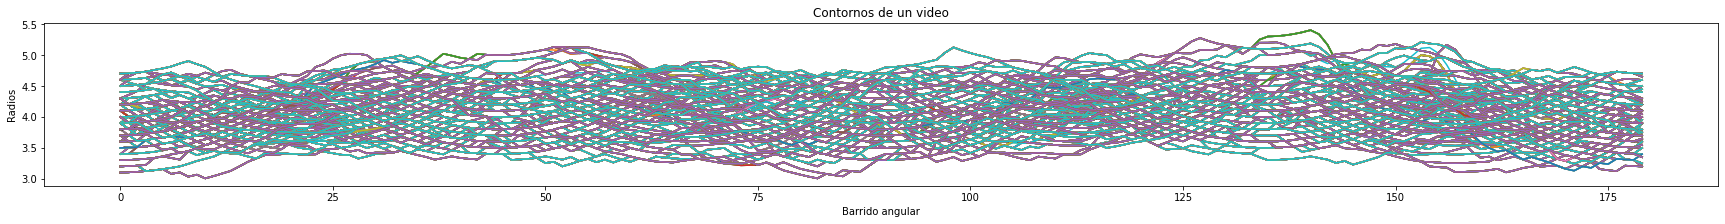

In [ ]:
R=r.T
R=R*escala
plt.figure(figsize=(30,3))
plt.plot(R[:,:])   # Dibuja el gráfico
plt.title("Contornos de un video")   # Establece el título del gráfico
plt.ylabel("Radios")   # Establece el título del eje x
plt.xlabel("Barrido angular")   # Establece el título del eje y
print('Grafico')

Obtenemos el valor mínimo y máximo entre los puntos del gráfico. 

>> En los dos siguientes bloques nos muestra la ubicacion de los valores minimos y maximos de todos los datos. por ejemplo:(array([9]), array([30])) significa barrido angular posicion 9, y frame 30. - Esto nos serviria para encontrar algun frame con algun problema de binarizacion o filtrado 

In [ ]:
np.where(R==np.amin(R))


(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 82, 82, 82, 82, 82, 82, 82, 82, 82,
        82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]),
 array([ 700,  701,  702,  703,  704,  705,  706,  707,  708,  709,  710,
         711,  712,  713,  714,  715,  716,  717,  718,  719,  720,  721,
         722,  723,  724, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057,
        1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
        1069, 1070, 1071, 1072, 1073, 1074]))

In [ ]:
np.where(R==np.amax(R))

(array([140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [ ]:
print(f'Valor minimo: {np.amin(R[:,:])} Valor maximo: {np.amax(R[:,:])}')

Valor minimo: 3.008 Valor maximo: 5.4035


Graficamos el radio promedio de cada frame.

Grafico [micrones]
Maximo: 4.472641666666667.
Minimo: 3.6848277777777785.
Promedio: 4.087022529246488.


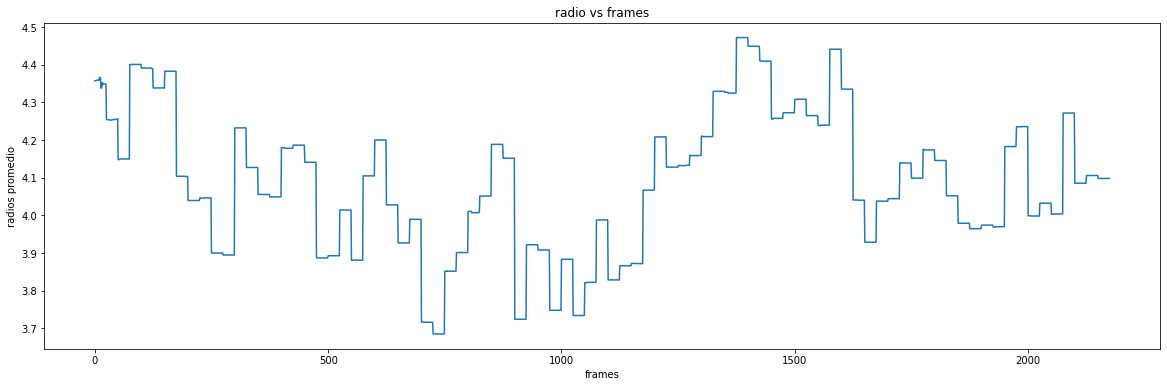

In [ ]:
Rpromedio=np.mean(r,axis=1)
Rpromedio_esca=Rpromedio*escala
Rprom=np.mean(Rpromedio)

plt.figure(figsize=(20,6))
plt.plot(Rpromedio_esca[:])   # Dibuja el gráfico
plt.title("radio vs frames")   # Establece el título del gráfico
plt.ylabel("radios promedio")   # Establece el título del eje x
plt.xlabel("frames")   # Establece el título del eje y

print('Grafico [micrones]')

print(f"Maximo: {max(Rpromedio_esca)}.")
print(f"Minimo: {min(Rpromedio_esca)}.")
print(f"Promedio: {np.mean(Rpromedio_esca)}.")


In [ ]:
radio_prom= Rprom*escala*(10**(-6)) #unidad(metros)
print(radio_prom)# en metros

4.087022529246487e-06


Calculamos los _Vq_

In [ ]:
AyBn=AyB*(1/Rprom)
AyBmedia=np.zeros([50,2])
AyBmedia[:,0]=np.mean(AyBn[:,:,0],axis=0)
AyBmedia[:,1]=np.mean(AyBn[:,:,1],axis=0)
#print(AyBmedia)
AyBresta=np.zeros([AyBn.shape[0],50,2])
for q in range(50):
  AyBresta[:,q,0]=AyBn[:,q,0]-AyBmedia[q,0]
  AyBresta[:,q,1]=AyBn[:,q,1]-AyBmedia[q,1]
AyBcuadrado=AyBresta*AyBresta
Vq=0.25*(np.mean(AyBcuadrado[:,:,0],axis=0)+np.mean(AyBcuadrado[:,:,1],axis=0))
print(Vq)

[5.38629705e-05 2.72736520e-03 2.01103576e-04 9.17940805e-05
 4.17375502e-05 3.44058585e-05 2.01621248e-05 1.32100891e-05
 1.01439764e-05 8.99832322e-06 6.29188673e-06 5.51877837e-06
 4.98381400e-06 3.60185213e-06 3.17446640e-06 2.30243802e-06
 2.12749501e-06 1.76744898e-06 1.86310286e-06 1.33436713e-06
 1.34547496e-06 1.13341876e-06 9.65154948e-07 8.85140443e-07
 8.21780138e-07 7.00204542e-07 5.93519977e-07 5.57273909e-07
 4.96543722e-07 4.61109919e-07 4.66054346e-07 4.12190292e-07
 4.00975012e-07 3.28169370e-07 3.60125665e-07 2.75381628e-07
 2.68368252e-07 2.78370749e-07 2.56335046e-07 2.61680232e-07
 2.64875773e-07 2.63631126e-07 2.43516033e-07 2.10770012e-07
 2.27899881e-07 2.05528698e-07 1.93011978e-07 1.81449311e-07
 1.86288557e-07 2.15510971e-07]


Se calculan los polinomios de legendre asociados, valuados en 0.

El valor q es el orden de derivación del polinomio.

El valor l es el grado del polinomio.

In [ ]:
q_max=50#order of the Legendre function derivation q menor o igual a l identico a m. Era 25 ''''''''''''''orden del polinimio
l_max=200 # degree of the Legendre function, identico a n ''''''''''''''''''''''''''''''''''''''''''''grado del polinomio
polypolderi=sc.lpmn(q_max, l_max, 0) #Aqui Pmn es Plq que seria q=m y l=n- --q orden de derev l grado del polonimio----- en 
#Return two arrays of size (m+1, n+1) containing Pmn(z) and Pmn'(z) for all orders from 0..m and degrees from 0..n.
#Retorna dos matrices de tamaño (m+1, n+1) que contienen Pmn(z) y Pmn'(z) para todos los órdenes desde 0..m y grados desde 0..n.
pol=polypolderi[0]
pol[0,:]# primer numero (q) orden del polinomio (asociado al orden de derivacion del polinomio) y el segundo(l) es el grado (asociado al grado de derivacion del polinomio)
# se muestran los polinomios de legendre de orden de derivacion 0, es decir,los propiamente dichos polinomios de legendre valuados en x=0

array([ 1.        ,  0.        , -0.5       , -0.        ,  0.375     ,
        0.        , -0.3125    , -0.        ,  0.2734375 ,  0.        ,
       -0.24609375, -0.        ,  0.22558594,  0.        , -0.20947266,
       -0.        ,  0.19638062,  0.        , -0.18547058, -0.        ,
        0.17619705,  0.        , -0.1681881 , -0.        ,  0.16118026,
        0.        , -0.15498102, -0.        ,  0.14944598,  0.        ,
       -0.14446445, -0.        ,  0.13994993,  0.        , -0.13583376,
       -0.        ,  0.1320606 ,  0.        , -0.12858532, -0.        ,
        0.12537069,  0.        , -0.12238567, -0.        ,  0.11960418,
        0.        , -0.11700409, -0.        ,  0.1145665 ,  0.        ,
       -0.11227517, -0.        ,  0.11011603,  0.        , -0.10807685,
       -0.        ,  0.10614691,  0.        , -0.10431679, -0.        ,
        0.10257817,  0.        , -0.10092369, -0.        ,  0.09934675,
        0.        , -0.0978415 , -0.        ,  0.09640265,  0.  

**Función** factor de normalizacion _Nlq_

image.png

In [ ]:
def factorn (q,l):
  factorial_resta=mt.factorial(l-q)
  factorial_suma=mt.factorial(l+q)
  pi=4*mt.pi
  factor_normalizacion=(((2*l)+1)/pi)*(factorial_resta/factorial_suma)
  return factor_normalizacion

FUNCION: CALCULAR DENOMINADOR, NUMERADOR Y LUEGO LA SUMATORIA

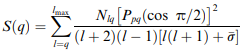

In [ ]:
def denom (l,tension):
  denominador=(l+2)*(l-1)*((l*(l+1))+tension)
  return denominador

In [ ]:
def numerad (q,l):
  numerador=factorn (q,l)*pol[q,l]*pol[q,l]
  return numerador

In [ ]:
def sumatoria (q,t):
  sumatoria=0
  for l in range(q,200):
    if l>=2:
      termino=numerad(q,l)/denom(l,t)
      sumatoria=sumatoria + termino
    Sq=sumatoria
  return Sq

FUNCION: calculamos k 

In [ ]:
def calculark (q):
  kBT=4*(10**(-21))#julios constate por temperatura en kelvin
  #radio_prom= 4.1*(10**(-6)) #metros 0.3micrometro
  kp=1.4*(10**(-18))
  teffp=1*(10**(-6))
  listateff=[]
  teffmin=1*(10**(-8))
  teffmax=1*(10**(-6))
  listateff.append(teffmin)
  listateff.append(teffmax)
  p=0
  error=100
  while error>1:
    p=p+1
    print(f"ciclo {p}")
    paso=(max(listateff)-min(listateff))/400
    inicio=min(listateff)
    fin=max(listateff)
    print(f" k: {kp}+/-{round(error,1)}%")
    for i in range(6):
      listak=[]
      for teff_indice in np.arange(inicio,fin,paso):#teff_idice es la teff que ira tomando valores del rango 
        t=(teff_indice*radio_prom*radio_prom)/kp# adimensional
        Sq=sumatoria (q,t)
        k=Sq*kBT/Vq[q]
        listak.append(k)
      kp=sum(listak)/float(len(listak))
      print(i,min(listak),max(listak))
      error=abs((max(listak)-min(listak))/kp)*40

    paso=(max(listak)-min(listak))/400
    inicio=min(listak)
    fin=max(listak)
    print(f" tension: {teffp}+/-{max(listateff)-min(listateff)}")
    for i in range (3):
      listateff=[]
      for k_indice in np.arange(inicio,fin,paso):
        t=(teffp*radio_prom*radio_prom)/k_indice# adimensional 
        Sq=sumatoria (q,t)
        teff=Sq*t*kBT/(Vq[q]*radio_prom*radio_prom)
        listateff.append(teff)
      teffp=sum(listateff)/float(len(listateff))
      print(i,min(listateff),max(listateff))
    print('-----')
  print('----------------------------------------')
  print(f" q={q}")
  print(f" k: {kp}+/-{round(error,1)}%")
  print(f" tension efectiva: {teffp}+/-{max(listateff)-min(listateff)}")
  print('----------------------------------------')  
  return kp

>> En el siguiente bloque vemos la funcion con la que se calculan los valores de k, en este vemos la tension efectiva  en la cuarta linea, en caso de ser nesesario podria cambiarse 

In [ ]:
def calculark (q):
  kBT=4*(10**(-21))#julios constate por temperatura en kelvin
  kp=1.4*(10**(-18))
  teff_indice=1*10**(-8)
  p=0
  error=100
  for i in range(6):
    t=(teff_indice*radio_prom*radio_prom)/kp# adimensional
    Sq=sumatoria (q,t)
    kp=Sq*kBT/Vq[q]
    print (kp)

    print('-----')
  print('----------------------------------------')
  print(f" q={q}")
  print(f" k: {kp}+/-{round(error,1)}%")
  print('----------------------------------------')  
  return kp

>> En este bloque en la linea del segundo for ente parentesis tenemos los valores en los que se tomara el valor promedio podemos cambiarlos segun nos parezca analizando el grafico de k vs q del siguiente bloque

In [ ]:
#este calculo puede tomar unos minutos

matriz_k=np.zeros((q_max,2)) #usamos la funcion mas importante
for i in range(0,q_max-1):
  matriz_k[i,1]=calculark (i)
  matriz_k[i,0]=i
print(matriz_k)
suma=0
can=0
for j in range(10,25): #rango para calcular el promedio de k
  suma=suma+matriz_k[j,1]
  can=can+1
promedio=suma/can
print (promedio)

3.2983791239597853e-19
-----
3.114403147199442e-19
-----
3.101077336713965e-19
-----
3.1000556757619644e-19
-----
3.099977014062849e-19
-----
3.099970955613219e-19
-----
----------------------------------------
 q=0
 k: 3.099970955613219e-19+/-100%
----------------------------------------
1.5318427303364754e-21
-----
2.043643151656219e-22
-----
3.465922557651245e-23
-----
6.348611395344231e-24
-----
1.1969840258489035e-24
-----
2.2787889417659166e-25
-----
----------------------------------------
 q=1
 k: 2.2787889417659166e-25+/-100%
----------------------------------------
1.2944901696805614e-19
-----
1.095916107168957e-19
-----
1.0635765954969228e-19
-----
1.0574000450714416e-19
-----
1.0561862299056625e-19
-----
1.0559463647927975e-19
-----
----------------------------------------
 q=2
 k: 1.0559463647927975e-19+/-100%
----------------------------------------
7.159117671159245e-20
-----
6.141841667756325e-20
-----
5.994724182671053e-20
-----
5.970068948845754e-20
-----
5.9658398551

k promedio 
1.735666678736168e-20


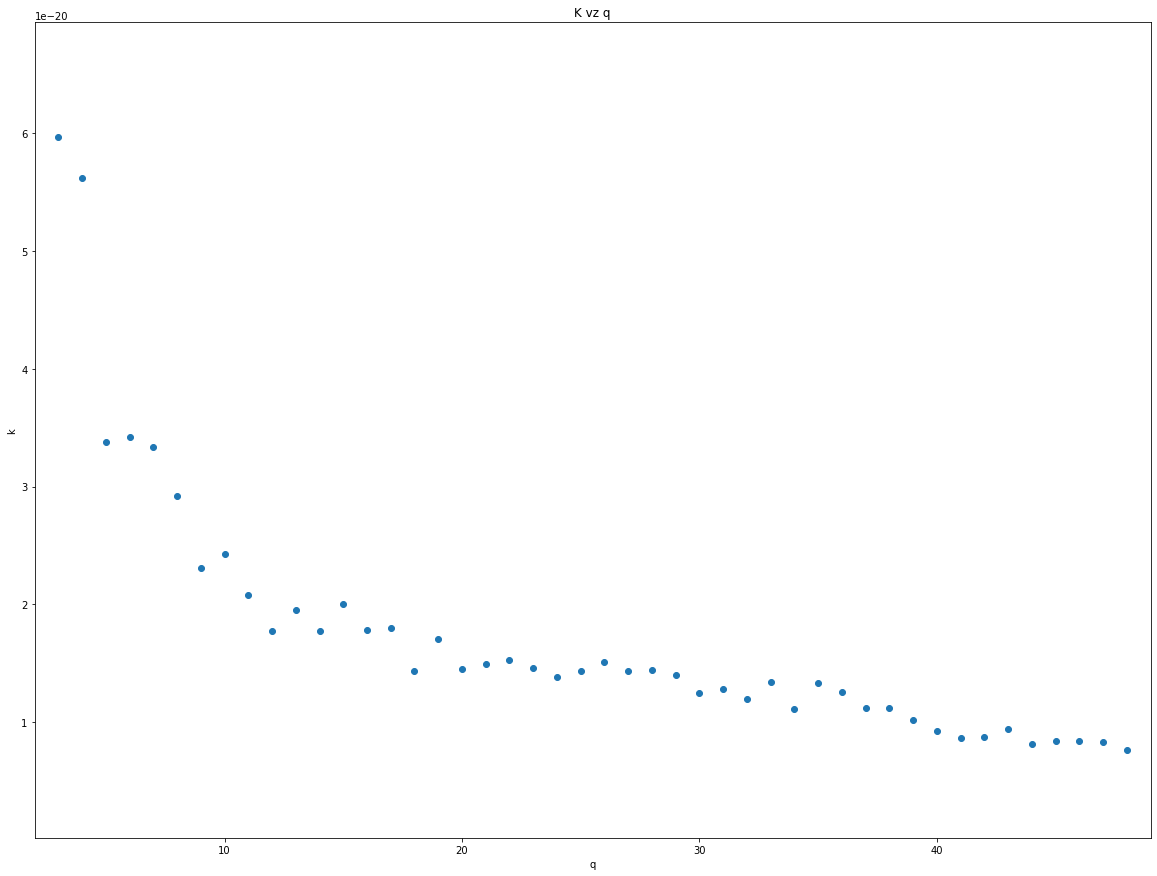

In [ ]:
kpromedio=promedio 
plt.figure(figsize=(20,15)) #tamaño del grafico
plt.scatter(matriz_k[:,0],matriz_k[:,1])   # Dibuja el gráfico
plt.title("K vz q")   # Establece el título del gráfico
plt.ylabel("k")   # Establece el título del eje x
plt.xlabel("q")   # Establece el título del eje y
limin=0.01*promedio #limite inferior de k
limsu=4*promedio  #limite superior de k
plt.ylim(limin,limsu)
plt.xlim(2,49)  #limites de q
#plt.yticks(np.arange(1*(10**(-18)),25*(10**(-19))))
#plt.xticks(np.arange(0,50,1))
print("k promedio ")
print (promedio)